# AutoGluon Tabular with SageMaker

[AutoGluon](https://github.com/awslabs/autogluon) automates machine learning tasks enabling you to easily achieve strong predictive performance in your applications. With just a few lines of code, you can train and deploy high-accuracy deep learning models on tabular, image, and text data.
This notebook shows how to use AutoGluon-Tabular with Amazon SageMaker by creating custom containers.

## Prerequisites

If using a SageMaker hosted notebook, select kernel `conda_mxnet_p36`.

In [1]:
import subprocess
# Make sure docker compose is set up properly for local mode
subprocess.run("./setup.sh", shell=True)

CompletedProcess(args='./setup.sh', returncode=0)

In [2]:
# For Studio
subprocess.run("apt-get update -y", shell=True)
subprocess.run("apt install unzip", shell=True)

CompletedProcess(args='apt install unzip', returncode=127)

In [3]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = 'sagemaker/autogluon-tabular'
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']

registry_uri_training = sagemaker.image_uris.retrieve('mxnet', region, version= '1.7.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='training')
registry_uri_inference = sagemaker.image_uris.retrieve('mxnet', region, version= '1.7.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='inference')
ecr_uri_prefix = account +'.'+'.'.join(registry_uri_training.split('/')[0].split('.')[1:])

### Build docker images

Build the training/inference image and push to ECR

In [4]:
training_algorithm_name = 'autogluon-sagemaker-training'
inference_algorithm_name = 'autogluon-sagemaker-inference'

First, you may want to remove existing docker images to make a room to build autogluon containers.

In [5]:
subprocess.run("docker system prune -af", shell=True)

CompletedProcess(args='docker system prune -af', returncode=0)

In [6]:
subprocess.run(f"/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}", shell=True)
subprocess.run("docker system prune -af", shell=True)

CompletedProcess(args='/bin/bash ./container-training/build_push_training.sh 332270294944 us-east-2 autogluon-sagemaker-training 332270294944.dkr.ecr.us-east-2.amazonaws.com 763104351884 763104351884.dkr.ecr.us-east-2.amazonaws.com/mxnet-training:1.7.0-cpu-py3', returncode=0)

CompletedProcess(args='docker system prune -af', returncode=0)

In [7]:
subprocess.run(f"/bin/bash ./container-inference/build_push_inference.sh {account} {region} {inference_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_inference}", shell=True)
subprocess.run("docker system prune -af", shell=True)

CompletedProcess(args='/bin/bash ./container-inference/build_push_inference.sh 332270294944 us-east-2 autogluon-sagemaker-inference 332270294944.dkr.ecr.us-east-2.amazonaws.com 763104351884 763104351884.dkr.ecr.us-east-2.amazonaws.com/mxnet-inference:1.7.0-cpu-py3', returncode=0)

CompletedProcess(args='docker system prune -af', returncode=0)

### Alternative way of building docker images using sm-docker

The new Amazon SageMaker Studio Image Build convenience package allows data scientists and developers to easily build custom container images from your Studio notebooks via a new CLI. 
Newly built Docker images are tagged and pushed to Amazon ECR. 

To use the CLI, you need to ensure the Amazon SageMaker execution role used by your Studio notebook environment (or another AWS Identity and Access Management (IAM) role, if you prefer) has the required permissions to interact with the resources used by the CLI, including access to CodeBuild and Amazon ECR. Your role should have a trust policy with CodeBuild. 

You also need to make sure the appropriate permissions are included in your role to run the build in CodeBuild, create a repository in Amazon ECR, and push images to that repository. 

See also: https://aws.amazon.com/blogs/machine-learning/using-the-amazon-sagemaker-studio-image-build-cli-to-build-container-images-from-your-studio-notebooks/

In [8]:
#subprocess.run("pip install sagemaker-studio-image-build", shell=True)

In [9]:
'''
training_repo_name = training_algorithm_name + ':latest'
training_repo_name  

!sm-docker build . --repository {training_repo_name} \
--file ./container-training/Dockerfile.training --build-arg REGISTRY_URI={registry_uri_training}

inference_repo_name = inference_algorithm_name + ':latest'
inference_repo_name  

!sm-docker build . --repository {inference_repo_name} \
--file ./container-inference/Dockerfile.inference --build-arg REGISTRY_URI={registry_uri_inference}
'''


"\ntraining_repo_name = training_algorithm_name + ':latest'\ntraining_repo_name  \n\n!sm-docker build . --repository {training_repo_name} --file ./container-training/Dockerfile.training --build-arg REGISTRY_URI={registry_uri_training}\n\ninference_repo_name = inference_algorithm_name + ':latest'\ninference_repo_name  \n\n!sm-docker build . --repository {inference_repo_name} --file ./container-inference/Dockerfile.inference --build-arg REGISTRY_URI={registry_uri_inference}\n"

### Get the data

In this example we'll use the direct-marketing dataset to build a binary classification model that predicts whether customers will accept or decline a marketing offer.  
First we'll download the data and split it into train and test sets. AutoGluon does not require a separate validation set (it uses bagged k-fold cross-validation).

In [10]:
# Download and unzip the data
subprocess.run(f"aws s3 cp --region {region} s3://sagemaker-sample-data-{region}/autopilot/direct_marketing/bank-additional.zip .", shell=True)
subprocess.run("unzip -qq -o bank-additional.zip", shell=True)
subprocess.run("rm bank-additional.zip", shell=True)

local_data_path = './bank-additional/bank-additional-full.csv'
data = pd.read_csv(local_data_path)

# Split train/test data
train = data.sample(frac=0.7, random_state=42)
test = data.drop(train.index)

# Split test X/y
label = 'y'
y_test = test[label]
X_test = test.drop(columns=[label])

CompletedProcess(args='aws s3 cp --region us-east-2 s3://sagemaker-sample-data-us-east-2/autopilot/direct_marketing/bank-additional.zip .', returncode=0)

CompletedProcess(args='unzip -qq -o bank-additional.zip', returncode=0)

CompletedProcess(args='rm bank-additional.zip', returncode=0)

##### Check the data

In [11]:
train.head(3)
train.shape

test.head(3)
test.shape

X_test.head(3)
X_test.shape

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no


(28832, 21)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


(12356, 21)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
10,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


(12356, 20)

Upload the data to s3

In [12]:
train_file = 'train.csv'
train.to_csv(train_file,index=False)
train_s3_path = session.upload_data(train_file, key_prefix='{}/data'.format(prefix))

test_file = 'test.csv'
test.to_csv(test_file,index=False)
test_s3_path = session.upload_data(test_file, key_prefix='{}/data'.format(prefix))

X_test_file = 'X_test.csv'
X_test.to_csv(X_test_file,index=False)
X_test_s3_path = session.upload_data(X_test_file, key_prefix='{}/data'.format(prefix))

## Hyperparameter Selection

The minimum required settings for training is just a target label, `init_args['label']`.

Additional optional hyperparameters can be passed to the `autogluon.tabular.TabularPredictor.fit` function via `fit_args`.

Below shows a more in depth example of AutoGluon-Tabular hyperparameters from the example [Predicting Columns in a Table - In Depth](https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-indepth.html). Please see [fit parameters](https://auto.gluon.ai/stable/_modules/autogluon/tabular/predictor/predictor.html#TabularPredictor) for further information. Note that in order for hyperparameter ranges to work in SageMaker, values passed to the `fit_args['hyperparameters']` must be represented as strings.

```python
nn_options = {
    'num_epochs': "10",
    'learning_rate': "ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)",
    'activation': "ag.space.Categorical('relu', 'softrelu', 'tanh')",
    'layers': "ag.space.Categorical([100],[1000],[200,100],[300,200,100])",
    'dropout_prob': "ag.space.Real(0.0, 0.5, default=0.1)"
}

gbm_options = {
    'num_boost_round': "100",
    'num_leaves': "ag.space.Int(lower=26, upper=66, default=36)"
}

model_hps = {'NN': nn_options, 'GBM': gbm_options} 

init_args = {
  'eval_metric' : 'roc_auc'  
  'label': 'y'
}

fit_args = {
  'presets': ['best_quality', 'optimize_for_deployment'],
  'time_limits': 60*10,
  'hyperparameters': model_hps,
  'hyperparameter_tune': True,
  'search_strategy': 'skopt'
}


hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```
**Note:** Your hyperparameter choices may affect the size of the model package, which could result in additional time taken to upload your model and complete training. Including `'optimize_for_deployment'` in the list of `fit_args['presets']` is recommended to greatly reduce upload times.

<br>

In [13]:
# Define required label and optional additional parameters
init_args = {
  'label': 'y'
}

# Define additional parameters
fit_args = {
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}

# Pass fit_args to SageMaker estimator hyperparameters
hyperparameters = {
  'init_args': init_args,   
  'fit_args': fit_args,
  'feature_importance': True
}

tags = [{
    'Key' : 'AlgorithmName',
    'Value' : 'AutoGluon-Tabular'
}]

## Train

For local training set `train_instance_type` to `local` .   
For non-local training the recommended instance type is `ml.m5.2xlarge`.   

**Note:** Depending on how many underlying models are trained, `train_volume_size` may need to be increased so that they all fit on disk.

In [14]:
%%time

instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

ecr_image = f'{ecr_uri_prefix}/{training_algorithm_name}:latest'

estimator = Estimator(image_uri=ecr_image,
                      role=role,
                      instance_count=1,
                      instance_type=instance_type,
                      hyperparameters=hyperparameters,
                      volume_size=100,
                      tags=tags)

# Set inputs. Test data is optional, but requires a label column.
inputs = {'training': train_s3_path, 'testing': test_s3_path}

estimator.fit(inputs)

2021-04-10 02:18:23 Starting - Starting the training job...
2021-04-10 02:18:25 Starting - Launching requested ML instancesProfilerReport-1618021103: InProgress
......
2021-04-10 02:19:49 Starting - Preparing the instances for training...
2021-04-10 02:20:23 Downloading - Downloading input data
2021-04-10 02:20:23 Training - Downloading the training image............
2021-04-10 02:22:16 Training - Training image download completed. Training in progress.2021-04-10 02:22:16,019 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-04-10 02:22:16,021 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-10 02:22:16,022 sagemaker-training-toolkit INFO     Failed to parse hyperparameter init_args value {'label': 'y'} to Json.
Returning the value itself
2021-04-10 02:22:16,022 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'presets': ['optimize_for_deployment']} to Json.
Returnin

### Review the performance of the trained model

In [15]:
from utils.ag_utils import launch_viewer

launch_viewer(is_debug=False)

HTML(value='\n        <style>\n            .output_scroll {\n                height: unset !important;\n      …

HTML(value="<b><font size=4 color='#000099'>AutoGluon Model Performance Viewer</font></b>")

interactive(children=(Dropdown(description='Job_Name', options=('-- Select job --', 'autogluon-sagemaker-train…

### Create Model

In [16]:
# Create predictor object
class AutoGluonTabularPredictor(Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         serializer=CSVSerializer(), 
                         deserializer=StringDeserializer(), **kwargs)

In [17]:
ecr_image = f'{ecr_uri_prefix}/{inference_algorithm_name}:latest'

if instance_type == 'local':
    model = estimator.create_model(image_uri=ecr_image, role=role)
else:
    #model_uri = os.path.join(estimator.output_path, estimator._current_job_name, "output", "model.tar.gz")
    model_uri = estimator.model_data
    model = Model(ecr_image, model_data=model_uri, role=role, sagemaker_session=session, predictor_cls=AutoGluonTabularPredictor)

### Batch Transform

For local mode, either `s3://<bucket>/<prefix>/output/` or `file:///<absolute_local_path>` can be used as outputs.

By including the label column in the test data, you can also evaluate prediction performance (In this case, passing `test_s3_path` instead of `X_test_s3_path`).

In [18]:
output_path = f's3://{bucket}/{prefix}/output/'
# output_path = f'file://{os.getcwd()}'

transformer = model.transformer(instance_count=1, 
                                instance_type=instance_type,
                                strategy='MultiRecord',
                                max_payload=6,
                                max_concurrent_transforms=1,                              
                                output_path=output_path)

transformer.transform(test_s3_path, content_type='text/csv', split_type='Line')
transformer.wait()

2021-04-10 02:30:49,449 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 6277 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 8
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2021-04-10 02:30:49,519 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - attachIOStreams() threadName=W-9000-model
2021-04-10 02:30:49,621 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model_service_worker started with args: --sock-type unix --sock-name /home/mod

### Endpoint

##### Deploy remote or local endpoint

In [19]:
instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=instance_type)

-------------!

##### Attach to endpoint (or reattach if kernel was restarted)

In [20]:
# Select standard or local session based on instance_type
if instance_type == 'local': 
    sess = local_session
else: 
    sess = session

# Attach to endpoint
predictor = AutoGluonTabularPredictor(predictor.endpoint_name, sagemaker_session=sess)

##### Predict on unlabeled test data

In [21]:
results = predictor.predict(X_test.to_csv(index=False)).splitlines()

# Check output
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print(Counter(y_results))

Counter({'no': 11305, 'yes': 1051})


##### Predict on data that includes label column  
Prediction performance metrics will be printed to endpoint logs.

In [22]:
results = predictor.predict(test.to_csv(index=False)).splitlines()

# Check output
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print(Counter(y_results))

Counter({'no': 11305, 'yes': 1051})


##### Check that classification performance metrics match evaluation printed to endpoint logs as expected

In [23]:
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print("accuracy: {}".format(accuracy_score(y_true=y_test, y_pred=y_results)))
print(classification_report(y_true=y_test, y_pred=y_results, digits=6))

accuracy: 0.918824862415021
              precision    recall  f1-score   support

          no   0.940380  0.969982  0.954952     10960
         yes   0.686965  0.517192  0.590110      1396

    accuracy                       0.918825     12356
   macro avg   0.813673  0.743587  0.772531     12356
weighted avg   0.911749  0.918825  0.913731     12356



##### Clean up endpoint

In [24]:
predictor.delete_endpoint()

## Explainability with Amazon SageMaker Clarify

There are growing business needs and legislative regulations that require explainations of why a model made a certain decision. SHAP (SHapley Additive exPlanations) is an approach to explain the output of machine learning models. SHAP values represent a feature's contribution to a change in the model output. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

##### Set parameters for SHAP calculation

In [25]:
seed = 0
num_rows = 500

#Write a csv file used by SageMaker Clarify
test_explainavility_file = 'test_explainavility.csv'
train.head(num_rows).to_csv(test_explainavility_file, index=False, header=False)
test_explainavility_s3_path = session.upload_data(test_explainavility_file, key_prefix='{}/data'.format(prefix))

##### Specify computing resources

In [26]:
from sagemaker import clarify

model_name = estimator.latest_training_job.job_name
container_def = model.prepare_container_def()
session.create_model(model_name,
                     role,
                     container_def)

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

'autogluon-sagemaker-training-2021-04-10-02-18-23-594'

##### Run a SageMaker Clarify job

In [27]:
shap_config = clarify.SHAPConfig(baseline=X_test.sample(15, random_state=seed).values.tolist(),
                                 num_samples=100,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/{}/clarify-explainability'.format(bucket, prefix, model_name)
explainability_data_config = clarify.DataConfig(s3_data_input_path=test_explainavility_s3_path,
                                s3_output_path=explainability_output_path,
                                label='y',
                                headers=train.columns.to_list(),
                                dataset_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-04-10-02-38-11-138
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-332270294944/sagemaker/autogluon-tabular/data/test_explainavility.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-10-02-18-23-594/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-traini

##### View the Explainability Report

You can view the explainability report in Studio under the experiments tab. If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [28]:
subprocess.run(f"aws s3 cp {explainability_output_path} . --recursive", shell=True)

CompletedProcess(args='aws s3 cp s3://sagemaker-us-east-2-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-10-02-18-23-594/clarify-explainability . --recursive', returncode=0)

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature.

In [29]:
subprocess.run(f"{sys.executable} -m pip install shap", shell=True)

CompletedProcess(args='/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install shap', returncode=0)

##### Compute global shap values out of out.csv

In [30]:
shap_values_ = pd.read_csv('explanations_shap/out.csv')
shap_values_.abs().mean().to_dict()

{'age_label0': 0.005711424907617532,
 'job_label0': 0.00577718851921522,
 'marital_label0': 0.005812037333344314,
 'education_label0': 0.006076651758493216,
 'default_label0': 0.006450849760709483,
 'housing_label0': 0.005776367107712825,
 'loan_label0': 0.005968522707879871,
 'contact_label0': 0.007082081877272052,
 'month_label0': 0.014998621875183004,
 'day_of_week_label0': 0.006079291202010962,
 'duration_label0': 0.08742300758265419,
 'campaign_label0': 0.005455853093708909,
 'pdays_label0': 0.008279902909714887,
 'previous_label0': 0.005977497577938787,
 'poutcome_label0': 0.007932544472242122,
 'emp.var.rate_label0': 0.027295479364939736,
 'cons.price.idx_label0': 0.007452170674245526,
 'cons.conf.idx_label0': 0.006412241153478637,
 'euribor3m_label0': 0.019735733533022572,
 'nr.employed_label0': 0.02038340878690671,
 'age_label1': 0.005711424304327524,
 'job_label1': 0.0057771880855821064,
 'marital_label1': 0.005812036795793644,
 'education_label1': 0.006076651358123135,
 'def

In [31]:
num_features = len(train.head(num_rows).drop(['y'], axis = 1).columns)

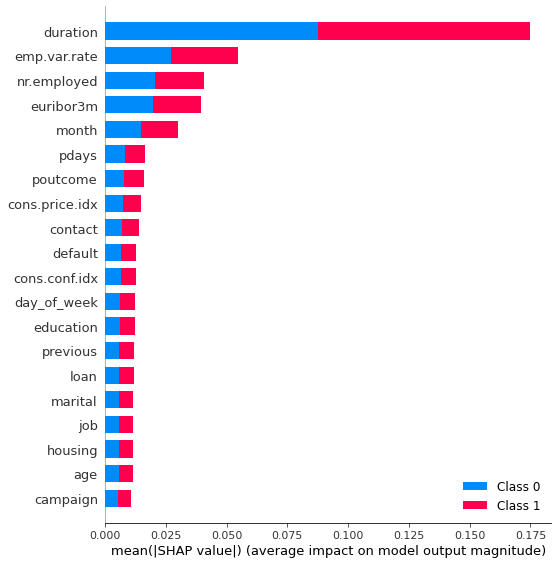

In [32]:
import shap
shap_values = [shap_values_.to_numpy()[:,:num_features], shap_values_.to_numpy()[:,num_features:]]
shap.summary_plot(shap_values, 
                  plot_type='bar', 
                  feature_names=train.head(num_rows).drop(['y'], axis = 1).columns.tolist())

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features).

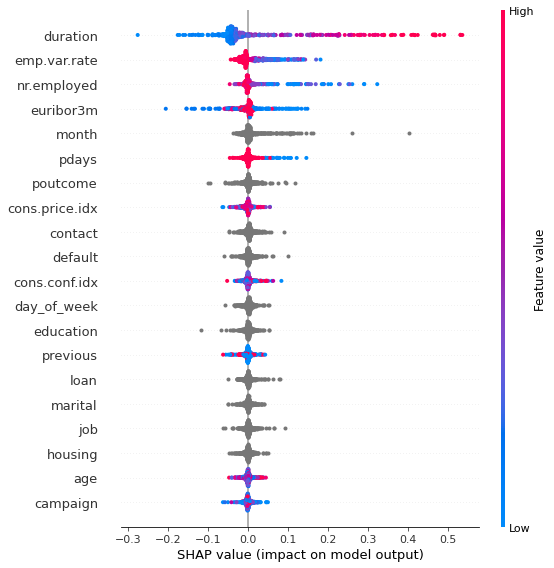

In [33]:
shap.summary_plot(shap_values_[shap_values_.columns[20:]].to_numpy(), 
                  train.head(num_rows).drop(['y'], axis = 1))